### Project Description : This is competition hosted by Data Driven. The objective is to predict which water pumps are functional, which need some repairs, and which don't work at all, a multiclass classifcation problem. The model produced managed to get 81.06% accuracy on test data, currently on top 14% of the leaderboeard.

##### Hypothesis / Assumptions made as following:-
##### 1. 'Date Recorded' which is described as the date row of observations is recorded will be assumed to be the date waterpoint is installed.
##### 2. Missing value for the field 'Construction Year' is assumed to be omitted unintentionally and will be imputed with the mean/other better method.
##### 3. Numerical features such as  'Amount_tsh', 'Population', 'GPS Height' & 'Longitude' are having value 0 and they will be assumed to be invalid and will be imputed. 
##### 4. Categorical features such as 'permit', ‘scheme_management‘ & ‘public_meeting are columns with valid value and missing value is assumed to be omitted unintentionally and will be imputed.


### 1. Import Dependencies Library

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import xgboost as xgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from fancyimpute import IterativeImputer as MICE
from datetime import datetime

import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/py

### 2. Load train & test set data

In [0]:
df_train = pd.read_csv("drive/My Drive/Data_Interchange/train_taarifa.csv",parse_dates=True)
y_train = pd.read_csv("drive/My Drive/Data_Interchange/y_train.csv")
df_test = pd.read_csv("drive/My Drive/Data_Interchange/test_taarifa.csv",parse_dates=True)
df_full = pd.concat([df_train,df_test],sort=False).drop('status_group',axis=1)

df_train_index = df_train.index.values
df_test_index = df_test.index.values

print(df_full.shape)
print(df_train.shape)
print(y_train.shape)
print(df_test.shape)

(74250, 40)
(59400, 41)
(59400, 2)
(14850, 40)


### 3. Exploratory Data Analysis

In [0]:
df_train.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [0]:
# Check if there is any missing data
# There are 7 columns with missing data
df_train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [0]:
# Check the counts of target variable

df_train['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

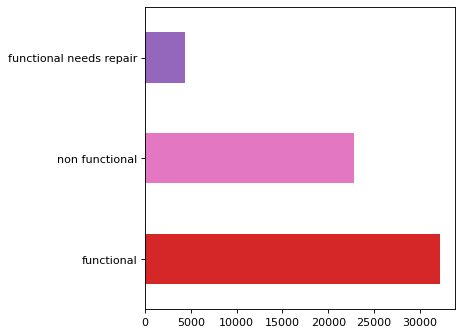

In [0]:
# Plot the bar chart to visualize target "status_group"

plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')

palette=[sns.color_palette()[3],sns.color_palette()[6],sns.color_palette()[4]]
y_train.status_group.value_counts().plot(kind='barh', color=palette)

Text(0.5, 0, 'Construction Year')

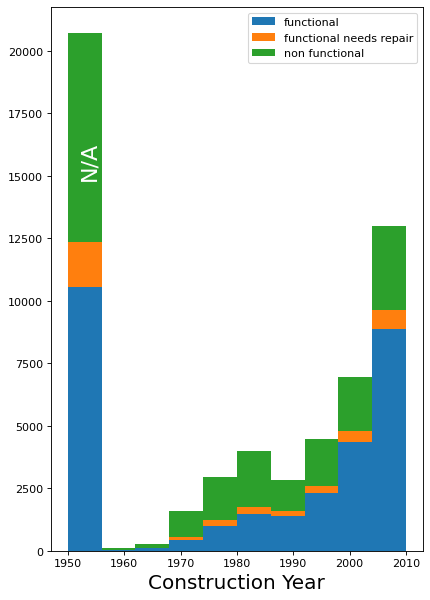

In [0]:
# Try visualize target "status_group" & plot its relationship with "construction_year"
# Relate to hypothesis 1

df_train.construction_year=pd.to_numeric(df_train.construction_year)
df_train.loc[df_train.construction_year <= 0, df_train.columns=='construction_year'] = 1950

hist1=df_train[df_train.status_group == 'functional'].construction_year
hist2=df_train[df_train.status_group == 'functional needs repair'].construction_year
hist3=df_train[df_train.status_group == 'non functional'].construction_year

plt.figure(figsize=(6, 9), dpi= 80, facecolor='w', edgecolor='k')
n,b,p=plt.hist([hist1, hist2, hist3], stacked=True,range=[1950,2010])
plt.legend(['functional','functional needs repair','non functional'],loc=0)
plt.text(1952, 15000,'N/A',fontsize=20,rotation=90,color='white')
plt.xlabel('Construction Year', fontsize=18)


In [0]:
#convert status group label into numerical data as training take numerical inputs

val_status_group={'functional':2, 'functional needs repair':1,
                   'non functional':0}
df_train['status_group_vals']=df_train.status_group.replace(val_status_group)

### 3. Data Transformation - Part 1

##### Treatment for categorical data

In [0]:
# For all categorical data, checking out the number of category in the field, only kept ideally the top 5, else as others.
df_train['funder'].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
One Desk One Chair           1
Tanzania Compasion           1
Dbsp                         1
Dv                           1
Insititutiona                1
Name: funder, Length: 1897, dtype: int64

In [0]:
# Divide all categorical columns into max 5 categories, else as others
# This will helps in model convergence
def top5bin_funder(row):
    if row['funder']=='Government Of Tanzania':
        return 'government'
    elif row['funder']=='Danida':
        return 'danida'
    elif row['funder']=='Hesawa':
        return 'hesawa'
    elif row['funder']=='Rwssp':
        return 'rwssp'
    elif row['funder']=='World Bank':
        return 'world_bank'    
    else:
        return 'other'

def top5bin_cleaning(row):
    if row['installer']=='DWE':
        return 'dwe'
    elif row['installer']=='Government':
        return 'government'
    elif row['installer']=='RWE':
        return 'rwe'
    elif row['installer']=='Commu':
        return 'commu'
    elif row['installer']=='DANIDA':
        return 'danida'    
    else:
        return 'other'

def top5bin_scheme(row):
    '''Keep top 5 values and set the rest to 'other'. '''
    if row['scheme_management']=='VWC':
        return 'vwc'
    elif row['scheme_management']=='WUG':
        return 'wug'
    elif row['scheme_management']=='Water authority':
        return 'wtr_auth'
    elif row['scheme_management']=='WUA':
        return 'wua'
    elif row['scheme_management']=='Water Board':
        return 'wtr_brd'
    else:
        return 'other'

df_train['funder']= df_train.apply(lambda row: top5bin_funder(row), axis=1)
df_test['funder']= df_test.apply(lambda row: top5bin_funder(row), axis=1)
df_train['installer']= df_train.apply(lambda row: top5bin_cleaning(row), axis=1)
df_test['installer']= df_test.apply(lambda row: top5bin_cleaning(row), axis=1)
df_train['scheme_management'] = df_train.apply(lambda row: top5bin_scheme(row), axis=1)
df_test['scheme_management'] = df_test.apply(lambda row: top5bin_scheme(row), axis=1)

##### Drop all the columns which are redundant columns with too many unique values, this would not bring any goods to model

In [0]:
df_train['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [0]:
df_train['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [0]:
# Eg. A few pairs of variables are similar :
# (waterpoint_type,waterpoint_type_group) & (source & source type) & etcs both are almost similar, can drop one of them

df_train=df_train.drop(['subvillage','scheme_name','recorded_by','waterpoint_type','source','quantity',
                        'payment','management','extraction_type','extraction_type_group','quality_group'],axis=1)
df_test=df_test.drop(['subvillage','scheme_name','recorded_by','waterpoint_type','source','quantity',
                      'payment','management','extraction_type','extraction_type_group','quality_group'],axis=1)

##### Fill the valid columns which contain blank value with "Unknown"/"Other"

In [0]:
df_train['scheme_management'].value_counts()

vwc         36793
other        8617
wug          5206
wtr_auth     3153
wua          2883
wtr_brd      2748
Name: scheme_management, dtype: int64

In [0]:
# Value : true and false, others imputed as unknown.
df_train.public_meeting = df_train.public_meeting.fillna('Unknown')
df_test.public_meeting = df_test.public_meeting.fillna('Unknown')
df_train.permit = df_train.permit.fillna('Unknown')
df_test.permit = df_test.permit.fillna('Unknown')

df_train.scheme_management = df_train.scheme_management.fillna('other')
df_test.scheme_management = df_test.scheme_management.fillna('other')

In [0]:
# Checking Null Values on train data, all data has been imputed accordingly
df_train.apply(lambda x: sum(x.isnull()), axis=0)

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type_class    0
management_group         0
payment_type             0
water_quality            0
quantity_group           0
source_type              0
source_class             0
waterpoint_type_group    0
status_group             0
status_group_vals        0
dtype: int64

In [0]:
# Statistics for full train/test dataset
df_full.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


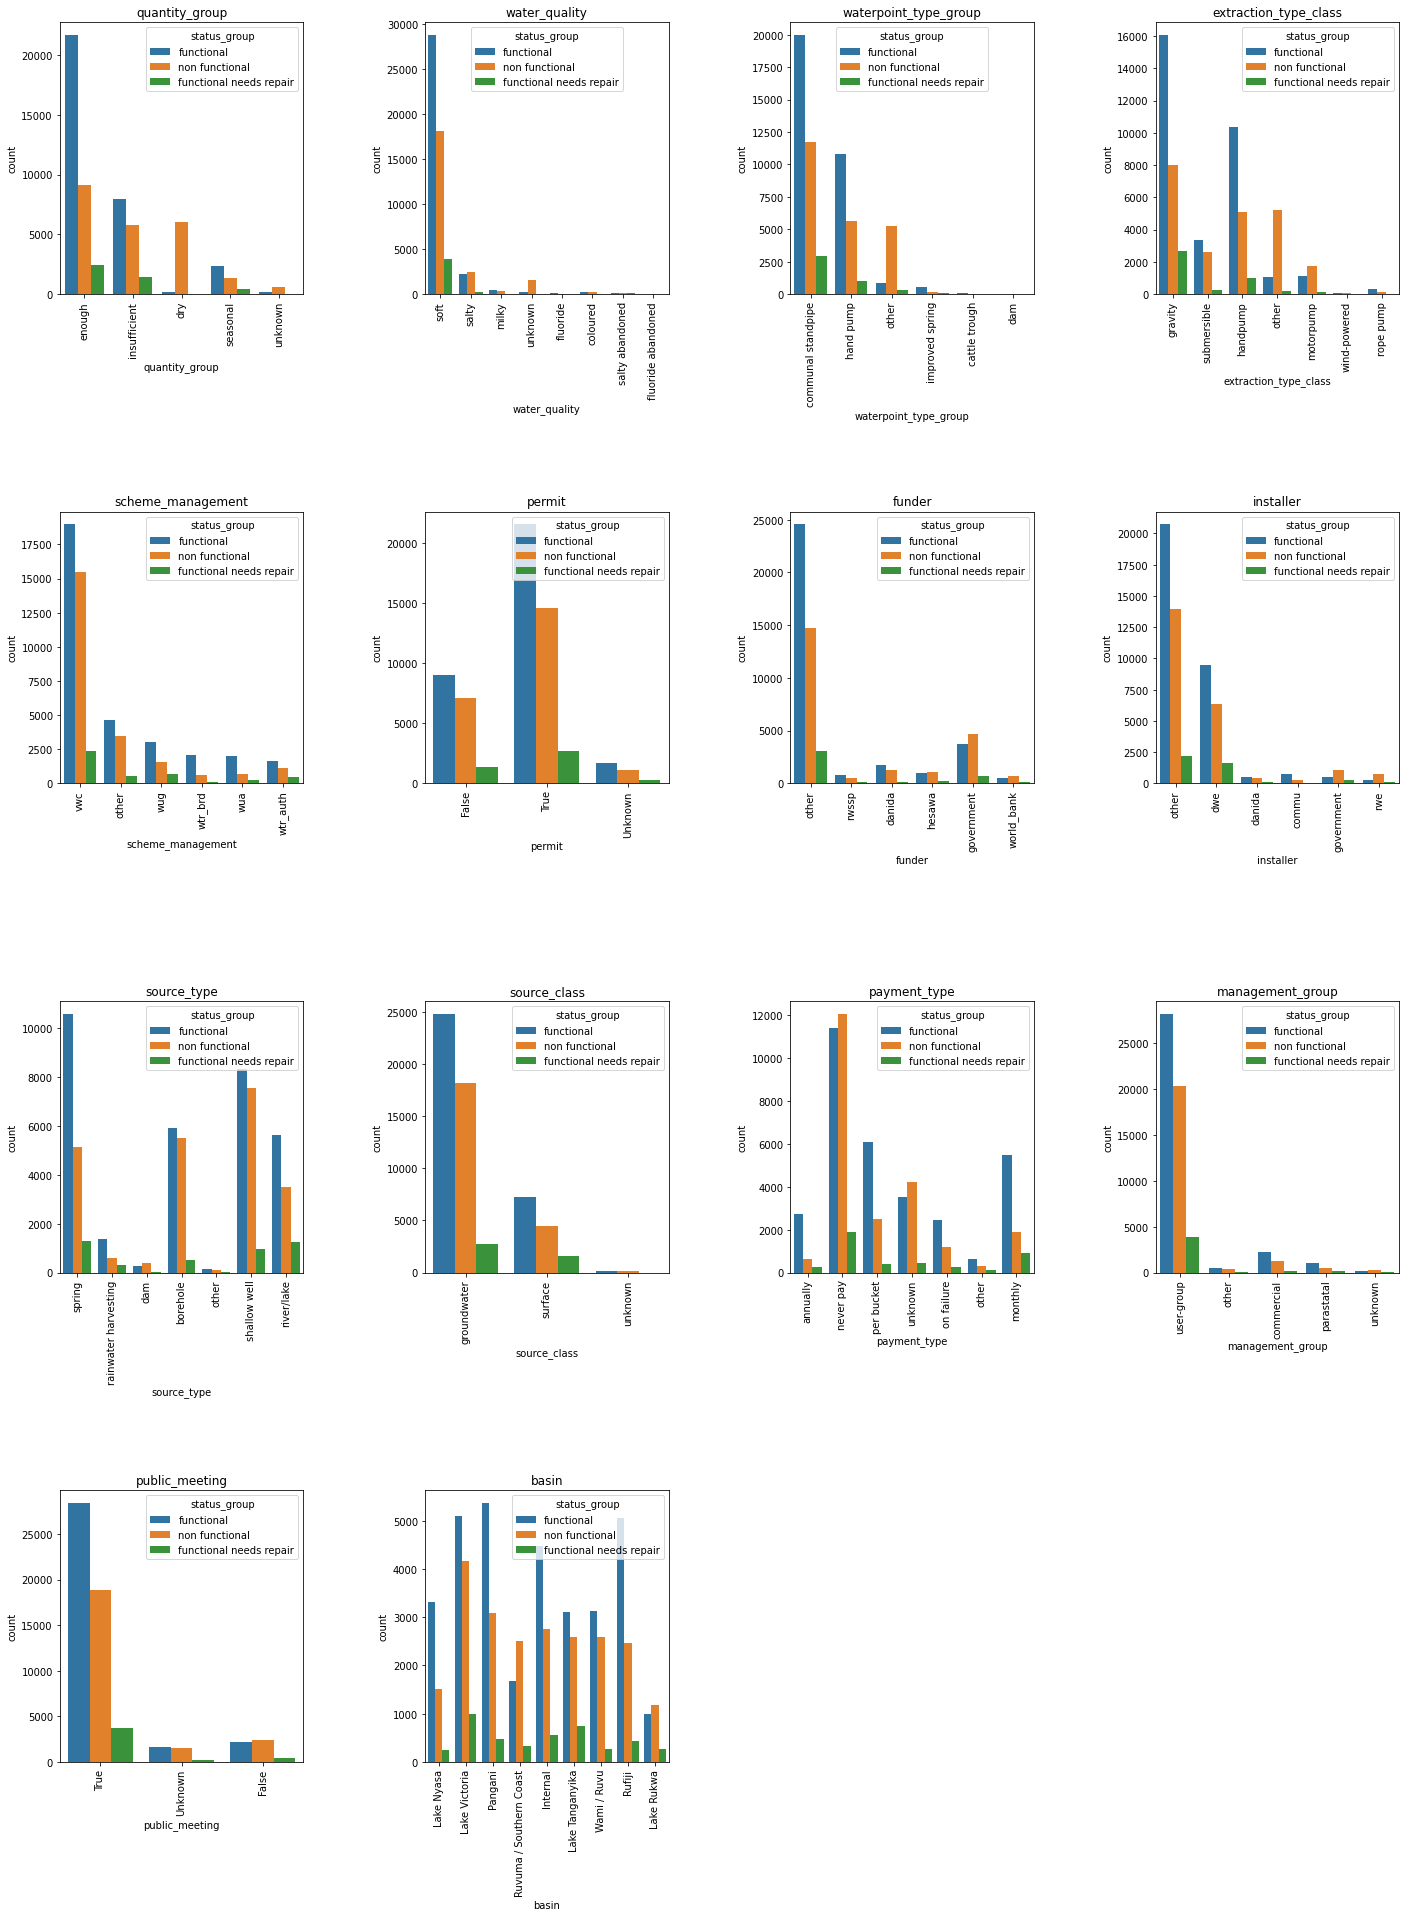

In [0]:
# Visualize of categorical column after transformation against target Y

plt.figure(figsize=(24,32))

# columns to plot
df_cat_cols=['quantity_group','water_quality','waterpoint_type_group','extraction_type_class','scheme_management',
             'permit','funder','installer','source_type','source_class','payment_type','management_group',
             'public_meeting','basin'] 

df_col_i = df_train.loc[:, df_cat_cols]
df_i = pd.concat([df_col_i, df_train['status_group']], axis=1)

for i, col in enumerate(df_cat_cols):
    plt.subplot(4, 4, i+1)
    sns.countplot(df_i[col], hue='status_group', data=df_i)
    plt.title(str(col))
    plt.subplots_adjust(hspace=0.8, wspace=0.5)
    plt.xticks(rotation=90)
plt.savefig('cat_col_with_label.png',dpi=300)
plt.show()

### Data Imputation (Mean/Median - depend on the distribution)
##### Tried IterativeImputer but doesn't work out so well so stick with mean/median.
#####  *** These are variables with invalid 0 value and need to be treated seperately.

In [0]:
### Imputation for invalid value 0 in numerical column with mean/median

# amount_tsh median equal to 0, no replacement done in first consideration 

def population_impute(row):
    if row['population']==0:
        return 25 #replace with median, skewed data
    else:
        return row['population']

def gpsheight_impute(row):
    if row['gps_height']==0:
        return 364 #replace with median, skewed data
    else:
        return row['gps_height']

def longitude_impute(row):
    if row['longitude']==0:
        return 34.074262
    else:
        return row['longitude']

df_train['population']= df_train.apply(lambda row: population_impute(row), axis=1)
df_test['population']= df_test.apply(lambda row: population_impute(row), axis=1)
df_train['gps_height']= df_train.apply(lambda row: gpsheight_impute(row), axis=1)
df_test['gps_height']= df_test.apply(lambda row: gpsheight_impute(row), axis=1)
df_train['longitude']= df_train.apply(lambda row: longitude_impute(row), axis=1)
df_test['longitude']= df_test.apply(lambda row: longitude_impute(row), axis=1)

### Feature engineering: Construction tenure can be useful to know the period of pump installed

In [0]:
df_train['date_recorded'] = pd.to_datetime(df_train['date_recorded'])
df_train['recorded_year'] = df_train['date_recorded'].dt.year
df_test['date_recorded'] = pd.to_datetime(df_test['date_recorded'])
df_test['recorded_year'] = df_test['date_recorded'].dt.year

def construct_tenure(row):
    if row['construction_year'] !=0:
        return (row['recorded_year']- row['construction_year'])
    else:
        return 15.295624 #replace with mean
df_train['construct_tenure'] = df_train.apply(lambda row: construct_tenure(row), axis=1)
df_test['construct_tenure'] = df_test.apply(lambda row: construct_tenure(row), axis=1)

df_train = df_train.drop(["construction_year","recorded_year","date_recorded"],axis=1)
df_test = df_test.drop(["construction_year","recorded_year","date_recorded"],axis=1)

In [0]:
# Data is clean for model training
# not too correlated to each other, good fit for model
df_train.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,status_group_vals,construct_tenure
id,1.000000,-0.005321,-0.004620,0.001732,0.001718,-0.002629,-0.003028,-0.003044,-0.002820,-0.004049,0.003761
amount_tsh,-0.005321,1.000000,0.068750,0.013681,-0.052670,0.002944,-0.026813,-0.023599,0.014918,0.053702,-0.008408
gps_height,-0.004620,0.068750,1.000000,-0.146137,0.038021,0.001484,-0.234831,-0.224710,0.075306,0.124133,0.017102
longitude,0.001732,0.013681,-0.146137,1.000000,-0.304252,0.045264,0.145185,0.254975,0.054591,-0.004995,-0.026931
latitude,0.001718,-0.052670,0.038021,-0.304252,1.000000,0.006837,-0.221018,-0.201020,-0.017276,0.014547,-0.013577
num_private,-0.002629,0.002944,0.001484,0.045264,0.006837,1.000000,-0.020377,-0.004478,0.003100,0.005021,0.001123
region_code,-0.003028,-0.026813,-0.234831,0.145185,-0.221018,-0.020377,1.000000,0.678602,0.093234,-0.108640,0.021939
district_code,-0.003044,-0.023599,-0.224710,0.254975,-0.201020,-0.004478,0.678602,1.000000,0.059890,-0.065687,-0.004406
population,-0.002820,0.014918,0.075306,0.054591,-0.017276,0.003100,0.093234,0.059890,1.000000,0.017454,-0.026871
status_group_vals,-0.004049,0.053702,0.124133,-0.004995,0.014547,0.005021,-0.108640,-0.065687,0.017454,1.000000,-0.234798


In [0]:
# Lastly drop those variable that seem superflous like 'num_private' & 'wpt_name which no extra info

df_train = df_train.drop(['num_private','wpt_name','lga','region','ward','status_group','id'], axis=1)
df_test = df_test.drop(['num_private','wpt_name','lga','region','ward','id'], axis=1)

##### One-hot encoding for categorical data

In [0]:
# Get dummy columns for the categorical columns and shuffle the data.
## As most model only can take numerical data as inputs.

dummy_cols = ['funder', 'installer', 'basin', 'public_meeting', 'scheme_management', 'permit',
              'extraction_type_class','management_group', 'payment_type', 'water_quality',
              'quantity_group', 'source_type', 'source_class','waterpoint_type_group'] #construction_year

df_train = pd.get_dummies(df_train, columns = dummy_cols)
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = pd.get_dummies(df_test, columns = dummy_cols)

In [0]:
print('Shape of training data',df_train.shape)
print('Shape of testing data',df_test.shape)

Shape of training data (59400, 90)
Shape of testing data (14850, 89)


In [0]:
df_train.corr()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,status_group_vals,construct_tenure,funder_danida,funder_government,funder_hesawa,funder_other,funder_rwssp,funder_world_bank,installer_commu,installer_danida,installer_dwe,installer_government,installer_other,installer_rwe,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,public_meeting_False,public_meeting_True,public_meeting_Unknown,scheme_management_other,scheme_management_vwc,scheme_management_wtr_auth,scheme_management_wtr_brd,scheme_management_wua,scheme_management_wug,permit_False,...,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
amount_tsh,1.000000,0.068750,0.013681,-0.052670,-0.026813,-0.023599,0.014918,0.053702,-0.008408,0.040410,-0.016381,-0.019273,0.008815,-0.015492,-0.007610,0.002080,0.006839,-0.000394,-0.004593,0.002643,-0.010546,-0.012888,0.022013,0.009353,-0.012452,-0.043650,-0.002865,0.053660,-0.008518,0.005554,-0.015798,0.025683,-0.019708,-0.012218,-0.000422,0.006709,-0.009845,0.048960,-0.019273,-0.023026,...,-0.011005,0.026322,-0.008443,-0.005508,0.187301,0.080813,-0.090005,-0.000151,0.000393,-0.038871,-0.042194,-0.004544,0.009043,-0.001793,-0.011569,-0.016959,-0.007483,0.025394,-0.014085,-0.021527,0.036329,-0.013098,-0.018309,-0.009732,-0.000474,-0.006881,-0.005682,-0.020510,0.054273,-0.047746,0.013612,-0.037000,0.038201,-0.005682,-0.004586,0.039472,-0.001150,-0.019800,-0.005608,-0.030951
gps_height,0.068750,1.000000,-0.146137,0.038021,-0.234831,-0.224710,0.075306,0.124133,0.017102,0.054869,0.035755,-0.035134,0.002315,-0.094197,-0.035903,0.131833,-0.017011,0.003142,-0.012150,-0.023668,-0.021693,0.157516,0.092206,0.001395,0.047930,-0.148973,0.184808,0.094046,-0.186810,-0.287615,-0.038912,0.039174,-0.012100,-0.104175,0.024368,0.066542,0.086941,0.101656,-0.106694,-0.091730,...,0.005650,0.007346,-0.004333,0.042116,0.186923,0.139813,-0.152353,0.054746,-0.036485,-0.116683,0.043811,-0.051030,0.034630,-0.010404,-0.076211,-0.143043,-0.056936,0.150693,0.011967,-0.076755,0.100268,-0.014825,-0.075304,-0.007013,-0.093428,-0.037885,-0.024986,0.012302,0.043001,-0.281915,0.334934,-0.031017,0.035332,-0.024986,0.026347,0.223170,-0.004497,-0.180230,0.012098,-0.098151
longitude,0.013681,-0.146137,1.000000,-0.304252,0.145185,0.254975,0.054591,-0.004995,-0.026931,-0.034826,0.084546,-0.164139,0.041642,-0.102668,0.032991,-0.008937,-0.010901,-0.118590,-0.039032,0.126764,0.012864,-0.025213,-0.103320,-0.220915,-0.522846,-0.379022,0.409494,0.111191,0.355622,0.361037,-0.022674,0.020607,-0.003693,0.081061,-0.009656,-0.139052,0.159619,0.051813,-0.132073,-0.005883,...,-0.031057,-0.019199,-0.008234,-0.076912,-0.064506,-0.013208,-0.039601,-0.077063,-0.025744,0.288035,-0.119252,-0.000259,0.024477,0.001762,-0.082864,0.126120,0.028242,-0.074380,-0.013618,0.003478,-0.036905,0.067788,-0.041998,-0.014768,0.126736,-0.013548,0.043071,-0.062099,-0.031404,-0.106660,0.043398,0.053230,-0.060667,0.043071,0.023086,0.164328,0.010353,-0.16458

In [0]:
# From the above correaltion table, it seem taht 
# waterpoint_type_group_hand pump is highly correlated with extraction_type_class_handpump,
# so will proceed to drop one of them

df_train=df_train.drop(['waterpoint_type_group_hand pump'],axis=1)
df_test=df_test.drop(['waterpoint_type_group_hand pump'],axis=1)

df_train=df_train.drop(['source_type_other'],axis=1)
df_test=df_test.drop(['source_type_other'],axis=1)


In [0]:
# Define Y & drop it from the train set to proceed for feature selection 

df_train_cp = df_train.copy()
target = df_train.status_group_vals
features = df_train.drop('status_group_vals', axis=1)
features1=features.copy()

### 4. Feature Selection / Feature Reduction 

In [0]:
# Set up timer to time feature selection process

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [0]:
# RandomForrestClassifier is used here as the estimator for Boruta. 
# The max_depth of the tree is advised to be between 3 to 7 for better result, set most setting to default.

rf = RandomForestClassifier(criterion='gini',
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1,
                                max_depth=6)

X_boruta=features.values
y_boruta=target.values

boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2)
start_time = timer(None)
boruta_selector.fit(X_boruta,y_boruta)
timer(start_time)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	87
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	87
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	87
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	87
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	87
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	87
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	87
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	67
Tentative: 	7
Rejected: 	13
Iteration: 	9 / 100
Confirmed: 	67
Tentative: 	7
Rejected: 	13
Iteration: 	10 / 100
Confirmed: 	67
Tentative: 	7
Rejected: 	13
Iteration: 	11 / 100
Confirmed: 	67
Tentative: 	7
Rejected: 	13
Iteration: 	12 / 100
Confirmed: 	69
Tentative: 	5
Rejected: 	13
Iteration: 	13 / 100
Confirmed: 	69
Tentative: 	5
Rejected: 	13
Iteration: 	14 / 100
Confirmed: 	69
Tentative: 	5
Rejected: 	13
Iteration: 	15 / 100
Confirmed: 	69
Tentative: 	5
Rejected: 	13
Iteration: 	16 / 100
Confirmed: 	69
Tentative: 	5
Reject

In [0]:
# number of selected features after feature selection process

print ('\n Number of selected features:')
print (boruta_selector.n_features_)


 Number of selected features:
69


In [0]:
# Put selected list into pandas DataFrame in ascending sort

features1=pd.DataFrame(features.columns.tolist())
features1['rank']=boruta_selector.ranking_
features1 = features1.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % boruta_selector.n_features_)
print (features1.head(boruta_selector.n_features_))


 Top 69 features:
                              0  rank
0                    amount_tsh     1
1        payment_type_never pay     1
2          payment_type_monthly     1
3         payment_type_annually     1
4   management_group_user-group     1
..                          ...   ...
64                 basin_Rufiji     1
65        basin_Lake Tanganyika     1
66                basin_Pangani     1
67          basin_Lake Victoria     1
68               basin_Internal     1

[69 rows x 2 columns]


In [0]:
# Boruta output with full list of features with ranking sorted ascendingly

features1=pd.DataFrame(features.columns.tolist())
features1['rank']=boruta_selector.ranking_
features1 = features1.sort_values('rank', ascending=True).reset_index(drop=True)
features1

,0,rank
0,amount_tsh,1
1,payment_type_never pay,1
2,payment_type_monthly,1
3,payment_type_annually,1
4,management_group_user-group,1
...,...,...
82,water_quality_coloured,14
83,extraction_type_class_wind-powered,15
84,waterpoint_type_group_cattle trough,16
85,waterpoint_type_group_dam,17


In [0]:
#Drop columns which Boruta didnt give/predict rank 1 importance

df_train=features.drop(['water_quality_milky','source_type_dam','payment_type_on failure','funder_hesawa',
                        'management_group_parastatal','water_quality_salty abandoned','management_group_unknown',
                        'management_group_other','extraction_type_class_rope pump','payment_type_other',
                        'installer_danida','water_quality_fluoride','source_class_unknown','water_quality_coloured',
                        'extraction_type_class_wind-powered','waterpoint_type_group_cattle trough',
                        'waterpoint_type_group_dam','water_quality_fluoride abandoned'],axis=1)

df_test=df_test.drop(['water_quality_milky','source_type_dam','payment_type_on failure','funder_hesawa',
                      'management_group_parastatal','water_quality_salty abandoned','management_group_unknown',
                      'management_group_other','extraction_type_class_rope pump','payment_type_other','installer_danida',
                      'water_quality_fluoride','source_class_unknown','water_quality_coloured','extraction_type_class_wind-powered',
                      'waterpoint_type_group_cattle trough','waterpoint_type_group_dam','water_quality_fluoride abandoned'],axis=1)

In [0]:
# Print final train & test set shape
print(df_train.shape)
print(df_test.shape)

(59400, 69)
(14850, 69)


In [0]:
# # Invalid value like 0 in some columns detected, will be imputed with IterativeImputer later

# def population_cleaning(train):
#     if train['population']==0:
#         return np.nan
#     else:
#         return train['population']

# def gpsheight_cleaning(train):
#     if train['gps_height']==0:
#         return np.nan
#     else:
#         return train['gps_height']

# def longitude_cleaning(train):
#     if train['longitude']==0:
#         return np.nan
#     else:
#         return train['longitude']

# def amounttsh_cleaning(train):
#     if train['amount_tsh']==0:
#         return np.nan
#     else:
#         return train['amount_tsh']

# df_train['population']= df_train.apply(lambda row: population_cleaning(row), axis=1)
# df_test['population']= df_test.apply(lambda row: population_cleaning(row), axis=1)
# df_train['gps_height']= df_train.apply(lambda row: gpsheight_cleaning(row), axis=1)
# df_test['gps_height']= df_test.apply(lambda row: gpsheight_cleaning(row), axis=1)
# df_train['longitude']= df_train.apply(lambda row: longitude_cleaning(row), axis=1)
# df_test['longitude']= df_test.apply(lambda row: longitude_cleaning(row), axis=1)
# df_train['amount_tsh']= df_train.apply(lambda row: amounttsh_cleaning(row), axis=1)
# df_test['amount_tsh']= df_test.apply(lambda row: amounttsh_cleaning(row), axis=1)

In [0]:
# # Check and see if there is missing value now as those invalid value 0 has been replaced with np.nan
# df_train.isnull().sum()

id                                              0
amount_tsh                                  41639
days_since_recorded                             0
gps_height                                  20438
longitude                                    1812
                                            ...  
source_class_groundwater                        0
source_class_surface                            0
waterpoint_type_group_communal standpipe        0
waterpoint_type_group_improved spring           0
waterpoint_type_group_other                     0
Length: 76, dtype: int64

In [0]:
# Save a copy for data normalization and scaler
df_train1 = df_train.copy()
df_test1 = df_test.copy()

In [0]:
# Get numerical & categorical columns
df_train_num_col = df_train1.select_dtypes(exclude=['category','object']).columns
df_train_cat_col = df_train1.select_dtypes(include=['category','object']).columns

print("Numeric cols : ", len(df_train_num_col))
print("Numeric cols : ", len(df_train_cat_col))

Numeric cols :  69
Numeric cols :  0


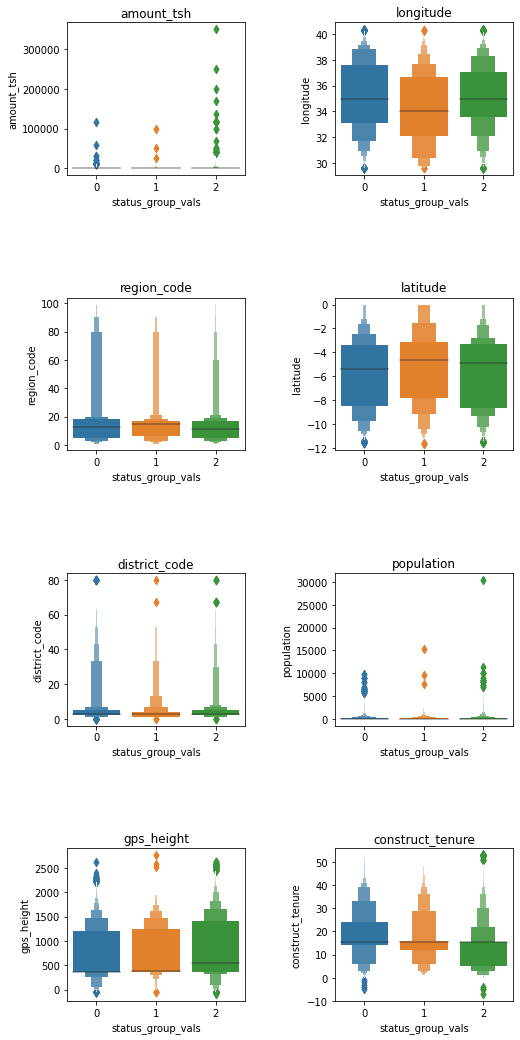

In [0]:
# Prepare for data transformation - Part 2 : Numerical data
# Visualize the relationship / distribution of numerical data with target - Boxplot

plt.figure(figsize=(8,18))

# columns to plot
df_num_cols=['amount_tsh','longitude','region_code', 'latitude','district_code','population', 'gps_height','construct_tenure'] 

df_col_i = df_train1.loc[:, df_num_cols]
df_i = pd.concat([df_col_i, df_train_cp['status_group_vals']], axis=1)

for i, col in enumerate(df_num_cols):
    plt.subplot(4, 2, i+1)
    sns.boxenplot(y=df_i[col], x=df_i['status_group_vals'])
    plt.title(str(col))
    plt.subplots_adjust(hspace=0.8, wspace=0.5)
    # plt.yscale('log')
plt.savefig('num_col_with_label.png',dpi=300)
plt.show()

<Figure size 1920x2560 with 0 Axes>

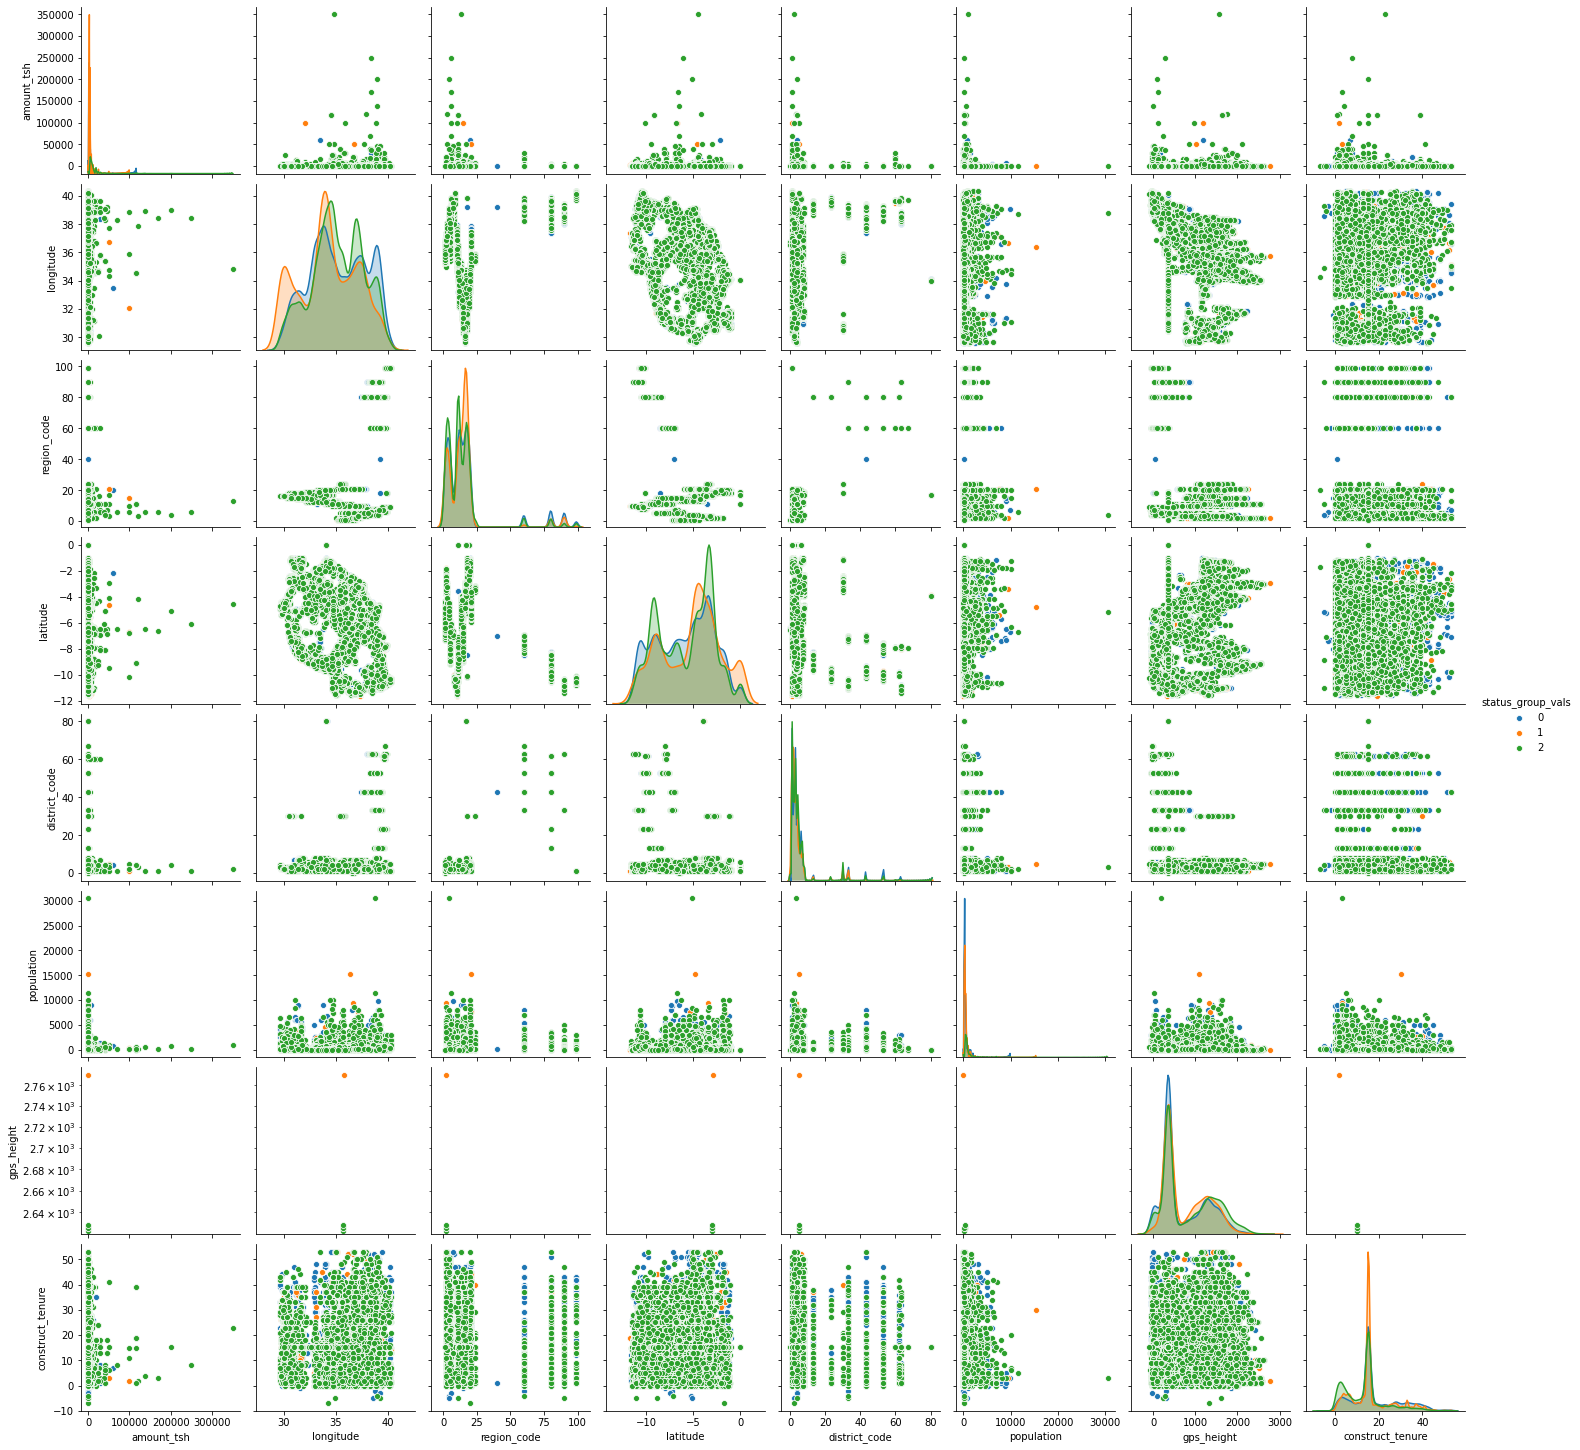

In [0]:
# Scatterplot with target Y

plt.figure(figsize=(24, 32), dpi= 80, facecolor='w', edgecolor='k')

df_col_i = df_train1.loc[:, df_num_cols]
df_i = pd.concat([df_col_i, df_train_cp['status_group_vals']], axis=1)

sns.pairplot(df_i, hue='status_group_vals')
plt.yscale('log')
plt.show()

### 5. Split Data into train & validation set

##### Chosen Train 90%: Validation 10% split as it turn out to give best accuracy.

In [0]:
X_train, X_val, y_train, y_val = train_test_split(df_train1, target, train_size=0.9, random_state=1085)

##### Perform Data Transformation - Part 2 (after train_test_split)

### Tried IterativeImputer (Imputation with multiple regression) but imputation only manage to give validation accuracy of 80.4% hence will not proceed for this case.

In [0]:
# # FancyImpute with MICE
# # Default method used is BayesianRidge

# # Use Logistic regression as the baseline
# logreg = make_pipeline(RobustScaler(), LogisticRegression())

# # Impute invalid/missing value
# # Fit_transform on training set
# mice = MICE(verbose=0)
# X_train_fancy_mice = mice.fit_transform(X_train)
# scores = cross_val_score(logreg, X_train_fancy_mice, y_train, cv=10)
# scores.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

0.7285634118967452

In [0]:
# # Then apply transformation to validation and test dataset to avoid data leakage
# col_list = X_train.columns.tolist()
# X_train_mice = pd.DataFrame(X_train_fancy_mice, columns=col_list)
# print(X_train_mice.shape)

# X_train_mice.head()

(53460, 76)


,id,amount_tsh,days_since_recorded,gps_height,longitude,latitude,region_code,district_code,population,funder_danida,funder_government,funder_other,funder_rwssp,funder_world_bank,installer_commu,installer_dwe,installer_government,installer_other,installer_rwe,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,public_meeting_False,public_meeting_True,public_meeting_Unknown,scheme_management_other,scheme_management_vwc,scheme_management_wtr_auth,scheme_management_wtr_brd,scheme_management_wua,scheme_management_wug,permit_False,permit_True,permit_Unknown,construction_year_00s,construction_year_10s,construction_year_70s,construction_year_80s,construction_year_90s,construction_year_unknown,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_submersible,management_group_commercial,management_group_user-group,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_per bucket,payment_type_unknown,water_quality_salty,water_quality_soft,water_quality_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_type_borehole,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,waterpoint_type_group_communal standpipe,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,61731.0,739.409176,263.0,993.0,36.798678,-3.493768,2.0,2.0,300.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,48281.0,2000.000000,873.0,1133.0,31.159952,-6.374470,15.0,1.0,240.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,37715.0,-682.719184,1029.0,760.0,30.576431,-6.998989,15.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,27455.0,750.000000,123.0,1071.0,29.872486,-4.621343,16.0,2.0,1500.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,62597.0,1171.586141,961.0,1599.0,35.121040,-9.248569,11.0,4.0,480.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [0]:
# # Check and see if there is missing value after MICE imputation
# # The invalid value has been imputed
# X_train_mice.isnull().sum()

id                                          0
amount_tsh                                  0
days_since_recorded                         0
gps_height                                  0
longitude                                   0
                                           ..
source_class_groundwater                    0
source_class_surface                        0
waterpoint_type_group_communal standpipe    0
waterpoint_type_group_improved spring       0
waterpoint_type_group_other                 0
Length: 76, dtype: int64

In [0]:
# # Apply transformation on validation & test dataset

# X_val_fancy_mice = mice.transform(X_val)
# df_test_fancy_mice = mice.transform(df_test)

# X_val_mice = pd.DataFrame(X_val_fancy_mice, columns=col_list)
# df_test_mice = pd.DataFrame(df_test_fancy_mice, columns=col_list)
# print(X_val_mice.shape)
# print(df_test_mice.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

(5940, 76)
(14850, 76)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

### Data Normalization / Scaling 
##### Good in removing outliers and provide better data distribution for model convergence.

In [0]:
# Columns intended for normalization/scaling
df_num_cols=['amount_tsh','longitude','region_code', 'latitude','district_code','population','gps_height','construct_tenure'] 

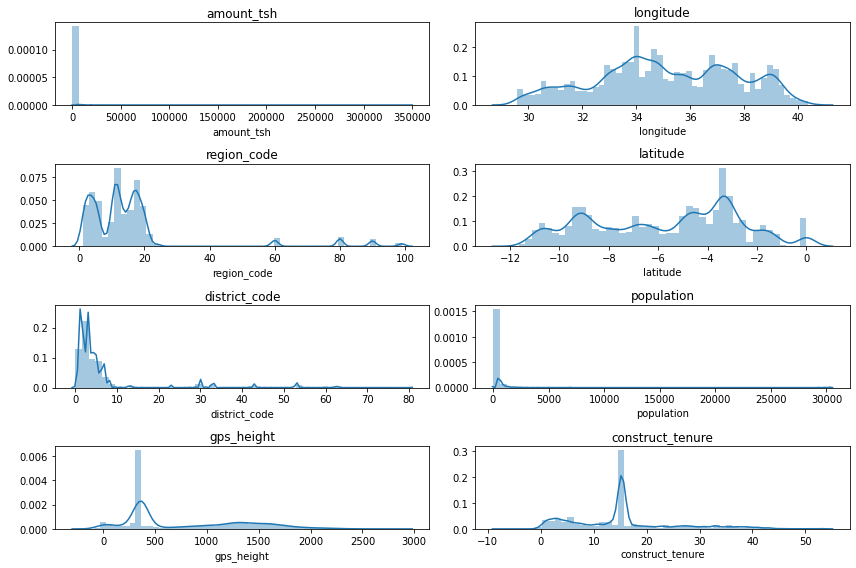

In [0]:
# Plot the distribution of numerical columns with histogram
plt.figure(figsize=(12,8))

for i, col in enumerate(df_num_cols):
    plt.subplot(4, 2, i + 1)
    sns.distplot(X_train[col])
    plt.title(str(col))
    plt.subplots_adjust(hspace=0.8, wspace=0.5)
    plt.tight_layout()
plt.show()

In [0]:
# Do normalization and scaling

# Train set normalization
X_train.amount_tsh = X_train.amount_tsh.apply(lambda x: np.log10(x+1))
X_train.longitude = X_train.longitude.apply(lambda x: np.log10(x+1))
X_train.region_code = X_train.region_code.apply(lambda x: np.log10(x+1))
X_train.district_code = X_train.district_code.apply(lambda x: np.log10(x+1))
X_train.population = X_train.population.apply(lambda x: np.log10(x+1))

# Validation set normalization
X_val.amount_tsh = X_val.amount_tsh.apply(lambda x: np.log10(x+1))
X_val.longitude = X_val.longitude.apply(lambda x: np.log10(x+1))
X_val.region_code = X_val.region_code.apply(lambda x: np.log10(x+1))
X_val.district_code = X_val.district_code.apply(lambda x: np.log10(x+1))
X_val.population = X_val.population.apply(lambda x: np.log10(x+1))

# Test set normalization
df_test1.amount_tsh = df_test1.amount_tsh.apply(lambda x: np.log10(x+1))
df_test1.longitude = df_test1.longitude.apply(lambda x: np.log10(x+1))
df_test1.region_code = df_test1.region_code.apply(lambda x: np.log10(x+1))
df_test1.district_code = df_test1.district_code.apply(lambda x: np.log10(x+1))
df_test1.population = df_test1.population.apply(lambda x: np.log10(x+1))

In [0]:
# # df_train1=df_train1.fillna(df_train1.mean())
# df_test1=df_test1.fillna(df_test1.mean())
# X_train_mice=X_train_mice.fillna(X_train_mice.mean())
# X_val_mice=X_val_mice.fillna(X_val_mice.mean())

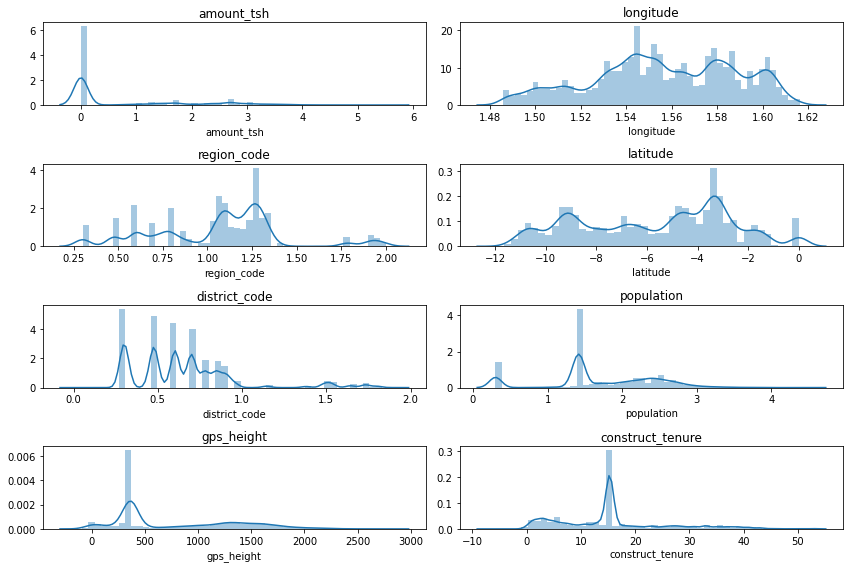

In [0]:
# Data distribution after normalization
plt.figure(figsize=(12,8))

for i, col in enumerate(df_num_cols):
    plt.subplot(4, 2, i + 1)
    sns.distplot(X_train[col])
    plt.title(str(col))
    plt.subplots_adjust(hspace=0.8, wspace=0.5)
    plt.tight_layout()
plt.show()

##### Data Scaling : To make data robust to outliers

In [0]:
# Scale the numerical variables can help model find pattern and faster convergence
# Gradient Boosting/Ensembles Tree algorithms is still prone to unnormalized/unscaled data due to bagging & boosting
rs =RobustScaler()

# Fit_transform should be done on only training data to avoid data leakage problem
X_train[df_num_cols] = rs.fit_transform(X_train[df_num_cols])

X_val[df_num_cols] = rs.transform(X_val[df_num_cols])
df_test1[df_num_cols] = rs.transform(df_test1[df_num_cols])

##### Data are now good to proceed to model training ...

### 6. Model Training

##### Hyperparameter tuning with GridSearchCV

In [0]:
# Model 1 : Linear Kernel SVM Classifier

def SVM_model(X_train, X_val, y_train, y_val):
    if __name__ == '__main__':
        
        #scl = StandardScaler()
        svm = LinearSVC()
        
        parameters = {'C':[0.001,0.01,0.1,1.0,10.0,100.0],'class_weight':[None, 'balanced']}

        estimator = GridSearchCV(svm, parameters,n_jobs=-1)

        estimator.fit(X_train, y_train)

        best_params = estimator.best_params_
                                 
        validation_accuracy = estimator.score(X_val, y_val)
        print('Validation accuracy: ', validation_accuracy)
        print(best_params)

In [0]:
SVM_model(X_train, X_val, y_train, y_val)

Validation accuracy:  0.717003367003367
{'C': 0.001, 'class_weight': 'balanced'}


In [0]:
# Model 2 : GBM

def GradientBoostingClassifier_model(X_train, X_val, y_train, y_val):
    if __name__ == '__main__':
        
        
        gb = GradientBoostingClassifier()
        
        parameters = {'learning_rate': [0.1],
                     'max_depth': [10],
                     'min_samples_leaf': [16],
                     "min_samples_split" : [8,12,16],
                    #  'max_features': ["log2","sqrt"],
                     "subsample":[0.5, 0.8, 0.95],
                     'n_estimators': [200]}
        
        estimator = GridSearchCV(gb,n_jobs=-1,param_grid=parameters)
        
        estimator.fit(X_train, y_train)

        best_params = estimator.best_params_
                                 
        validation_accuracy = estimator.score(X_val, y_val)
        print('Validation accuracy: ', validation_accuracy)
        print(best_params)

In [0]:
GradientBoostingClassifier_model(X_train, X_val, y_train, y_val)

Validation accuracy:  0.7977272727272727
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': 0.6, 'min_samples_leaf': 16, 'min_samples_split': 8, 'n_estimators': 200, 'subsample': 0.95}


In [0]:
# Model 3 : Random Forest

def RandomForestClassifier_model(X_train, X_val, y_train, y_val):
    if __name__ == '__main__':
        
        
        rf = RandomForestClassifier()
        
        parameters = {'max_samples' : [0.8],
                      'max_depth': [16,22],
                      'n_estimators': [500,1000]}
        
        estimator = GridSearchCV(rf,n_jobs=-1,param_grid=parameters,verbose=2,cv=5)

        estimator.fit(X_train, y_train)

        best_params = estimator.best_params_
                                 
        validation_accuracy = estimator.score(X_val, y_val)
        print('Validation accuracy: ', validation_accuracy)
        print(best_params)

In [0]:
RandomForestClassifier_model(X_train, X_val, y_train, y_val) 

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.7min finished


Validation accuracy:  0.8213804713804714
{'max_depth': 22, 'max_samples': 0.8, 'n_estimators': 1000}


In [0]:
rf = RandomForestClassifier(
                      max_samples = 0.8,
                      max_depth= 22,
                    #   n_jobs=1,
                    #   oob_score=True,
                      n_estimators= 1000)
 

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=22, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rf.score(X_val, y_val)

0.8181818181818182

In [0]:
rf_predictions = rf.predict(df_test1)

test_rf = pd.DataFrame(rf_predictions,columns=['status_group'])

predict_rf1 = pd.concat([test_rf, df_test], axis=1)

predict_rf1a = predict_rf1[['id','status_group']]
predict_rf1a = predict_rf1a.astype({"id":'object', "status_group":'object'}) 

def parse_values(x):
    if x == 2: 
        return 'functional'
    elif x == 1: 
        return 'functional needs repair'
    elif x == 0: 
        return 'non functional'

predict_rf1a['status_group'] = predict_rf1a['status_group'].apply(parse_values)

predict_rf1a = predict_rf1a.reset_index(drop=True).set_index('id')

predict_rf1a.to_csv('pred_rf.csv')


In [0]:
# Model 4 : XGBoost

def XGBoost_model(X_train, X_val, y_train, y_val):
    if __name__ == '__main__':
        
        
        xgboost = xgb.XGBClassifier()
        
        parameters = {'nthread':[4], 
                      'objective':['multi:softprob'],
                      'num_class':[3],
                      'eta': [0.05],
                      'max_depth': [10,15],
                    #   'lambda' : [0.01],
                      'alpha' : [0.1],
                      'colsample_bylevel': [0.6],
                      'colsample_bytree': [0.7],
                      'seed': [103734],
                      'n_estimators': [100,200]}
        
        estimator = GridSearchCV(xgboost,n_jobs=-1,param_grid=parameters,
                                 cv = 5,
                                 scoring='accuracy',
                                 verbose=3,refit=True)
        

        estimator.fit(X_train, y_train)

        best_params = estimator.best_params_
                                 
        validation_accuracy = estimator.score(X_val, y_val)
        print('Validation accuracy: ', validation_accuracy)
        print(best_params)

In [0]:
XGBoost_model(X_train, X_val, y_train, y_val)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 66.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 66.2min finished


Validation accuracy:  0.8191919191919191
{'alpha': 0.1, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.7, 'eta': 0.05, 'max_depth': 15, 'n_estimators': 100, 'nthread': 4, 'num_class': 3, 'objective': 'multi:softprob', 'seed': 103734}


In [0]:
#final for xgboost

xgbf = xgb.XGBClassifier(nthread=4, 
                      objective='multi:softprob',
                      num_class=3,
                      eta=0.05,
                      max_depth=15,
                      max_bin=256,
                      min_child_weight=0.1,
                      gamma=0.0,
                    #   lambda = 0.01,
                      alpha =0.1,
                      colsample_bylevel=0.6,
                      colsample_bytree=0.7,
                      seed=103734,
                      n_estimators=100)
        

xgbf.fit(X_train, y_train)

XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree',
              colsample_bylevel=0.6, colsample_bynode=1, colsample_bytree=0.7,
              eta=0.05, gamma=0.0, learning_rate=0.1, max_bin=256,
              max_delta_step=0, max_depth=15, min_child_weight=0.1,
              missing=None, n_estimators=100, n_jobs=1, nthread=4, num_class=3,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=103734, silent=None,
              subsample=1, verbosity=1)

In [0]:
xgbf.score(X_val,y_val)

0.8163299663299664

### Final Model for submission : Random Forest (Validation Accuracy : 0.8181)



In [0]:
# RF Model

rf = RandomForestClassifier(
                      max_samples = 0.8,
                      max_depth= 22,
                    #   n_jobs=1,
                    #   oob_score=True,
                      n_estimators= 1000)
 

rf.fit(X_train, y_train)

# Inference
rf_predictions = rf.predict(df_test1)

test_rf = pd.DataFrame(rf_predictions,columns=['status_group'])

predict_rf1 = pd.concat([test_rf, df_test], axis=1)

predict_rf1a = predict_rf1[['id','status_group']]
predict_rf1a = predict_rf1a.astype({"id":'object', "status_group":'object'}) 

def parse_values(x):
    if x == 2: 
        return 'functional'
    elif x == 1: 
        return 'functional needs repair'
    elif x == 0: 
        return 'non functional'

predict_rf1a['status_group'] = predict_rf1a['status_group'].apply(parse_values)

predict_rf1a = predict_rf1a.reset_index(drop=True).set_index('id')

predict_rf1a.to_csv('pred_rf.csv')


### 7. Model Visualization : Features Importance, Permutation Importance & Partial Dependence Plot



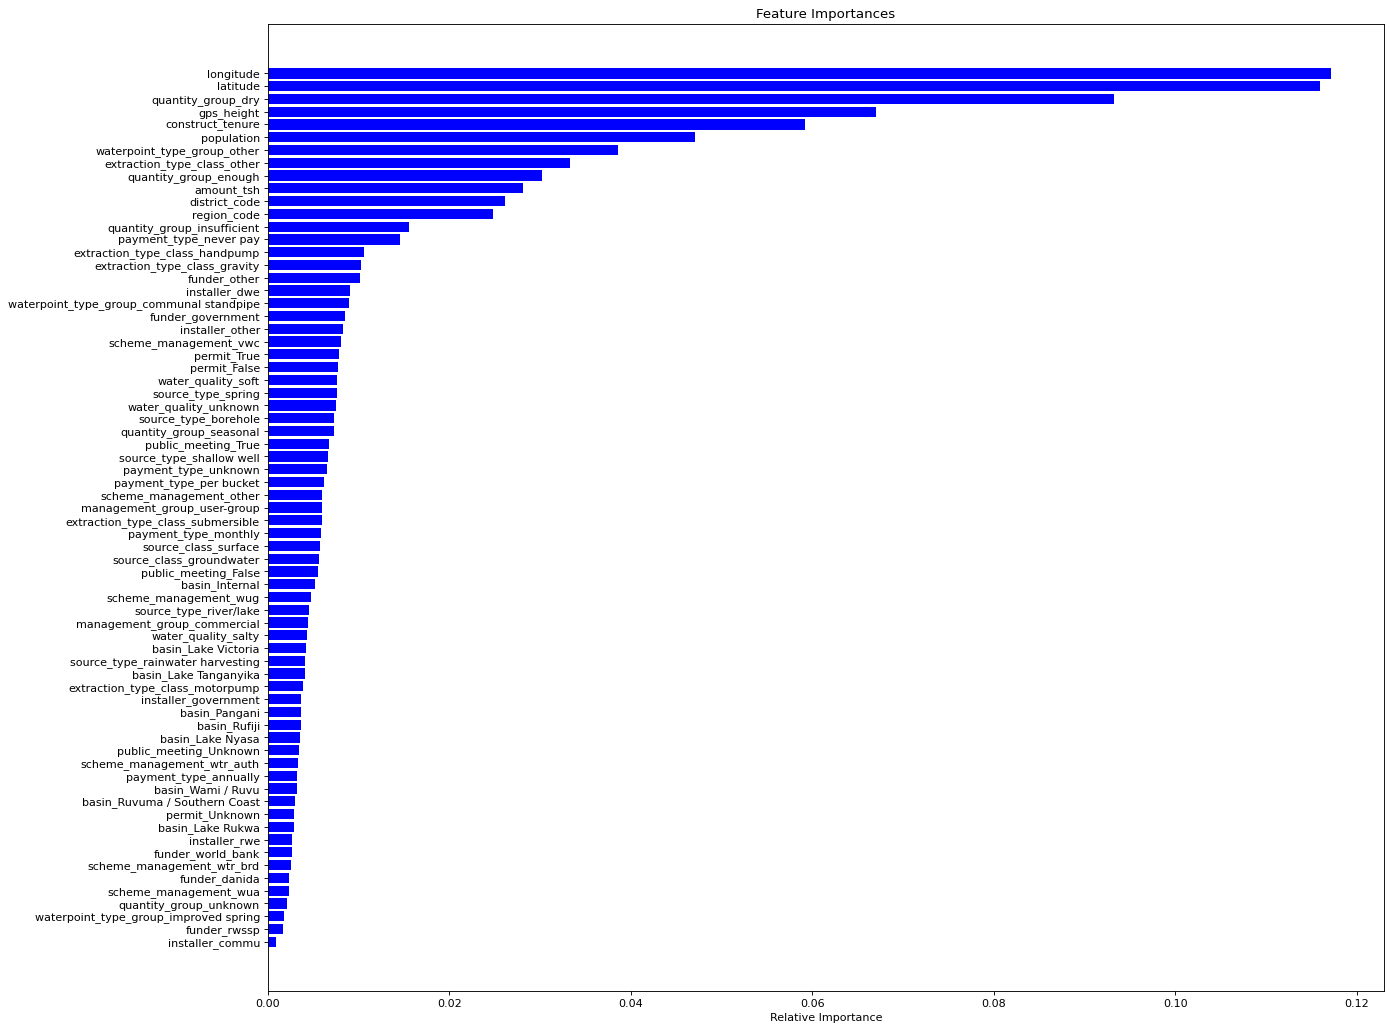

In [0]:
# Plotting features importance

plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

features = df_train1.columns.tolist()
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Permutation Importance

##### The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

##### The permutation importance is the measure of performance of the respective column with randomness introduced in the column by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

In [0]:
### Permutation Importance

perm = PermutationImportance(rf, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.0746 ± 0.0026,quantity_group_dry
0.0161 ± 0.0037,quantity_group_enough
0.0133 ± 0.0017,longitude
0.0129 ± 0.0046,construct_tenure
0.0127 ± 0.0028,latitude
0.0123 ± 0.0038,waterpoint_type_group_other
0.0094 ± 0.0008,amount_tsh
0.0090 ± 0.0021,extraction_type_class_other
0.0081 ± 0.0026,population
0.0072 ± 0.0029,payment_type_never pay


### Partial Dependence Plot
##### Partial dependence plot (PDP) is good at visualizing & capturing realistic patterns in the model. Y axis of the plot is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value while blue shaded area indicates level of confidence.
--------------------------------------------------------------------------
##### Below are some analysis findings:-
##### 1) When the water point is dry, it tends to increase the non-functionality chances of the water point.
##### 2) As the construction tenure increase up to 30 years, it tends to increase the malfunctioned chances of the water point. However after 30 years, the chances of non-functionality will remain the same.
##### 3) When the water point group belongs to others (instead of communal standpipe and etc.), it increases the chances of non-functionality.
##### 4) When the extraction type class belongs to others (instead of gravity, hand pump and etc.), it increases the chances of non-functionality.
##### 5) The chances of non-functionality peak when the population size is at its median and there is little marginal effect of population size thereafter.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


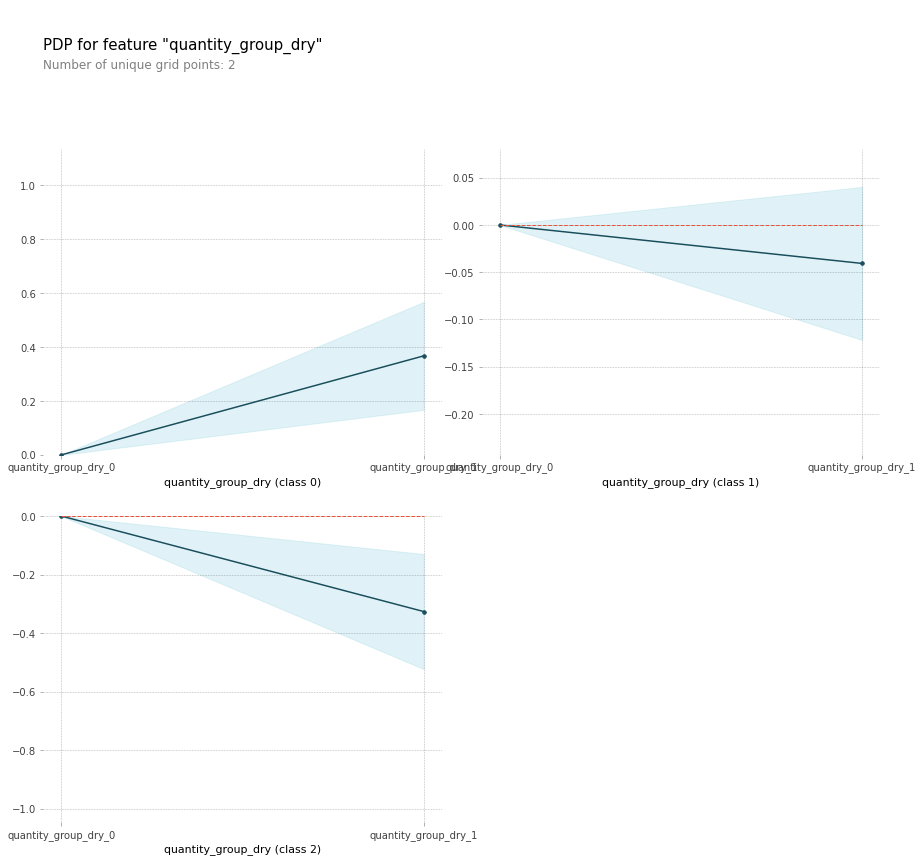

In [0]:
# Plot Partial Dependence Plot for top permutation important & feature important variables
# PDP 1a - Quantity_Group_Dry

feature_names = df_train.columns.tolist()
feature_to_plot = 'quantity_group_dry'

pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val, model_features=feature_names, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

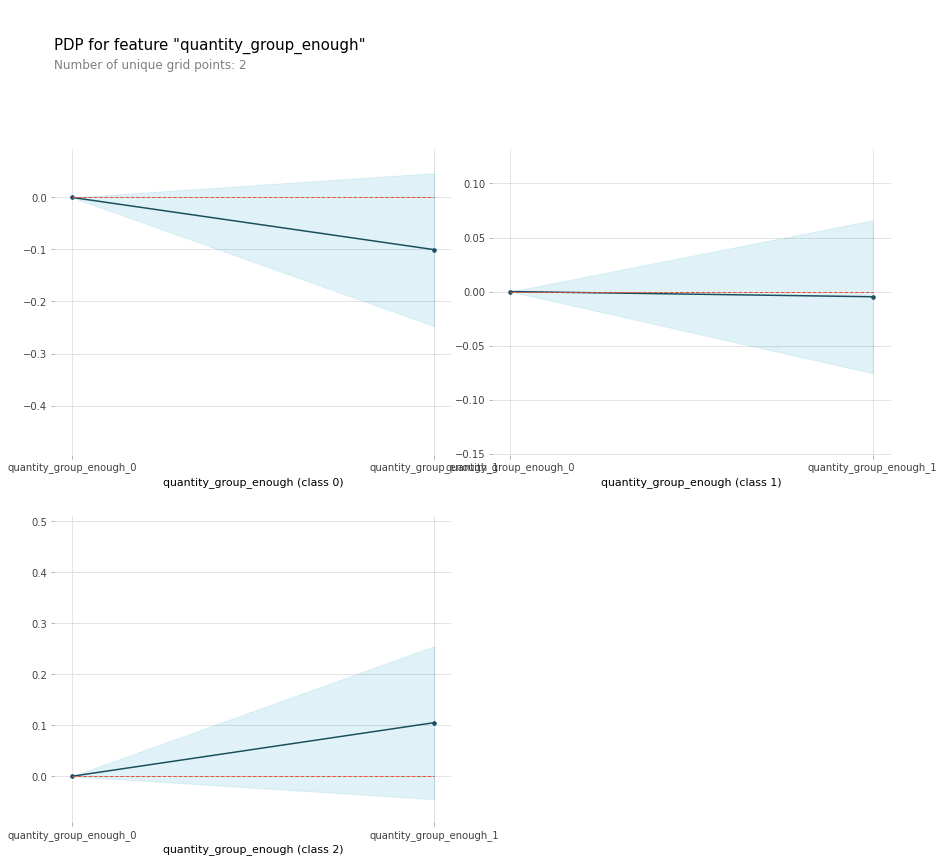

In [0]:
# PDP 1b - Quantity_Group_Enough

feature_names = df_train.columns.tolist()
feature_to_plot = 'quantity_group_enough'

pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val, model_features=feature_names, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

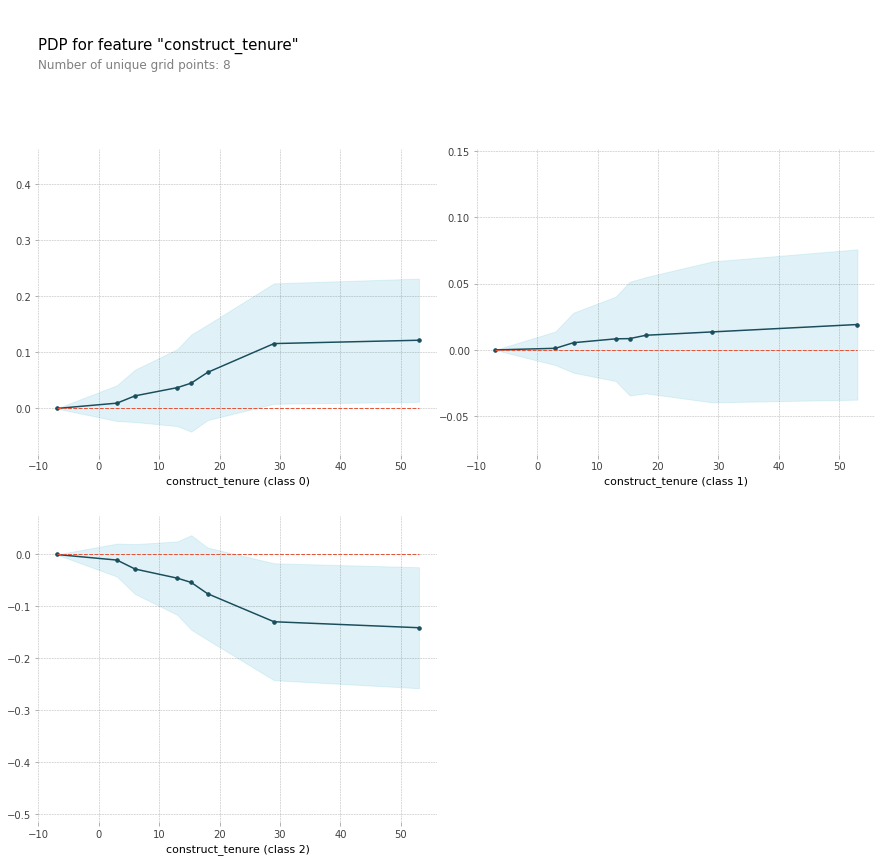

In [0]:
# PDP 2 - Construction Tenure 
feature_names = df_train.columns.tolist()
feature_to_plot = 'construct_tenure'

pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val, model_features=feature_names, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

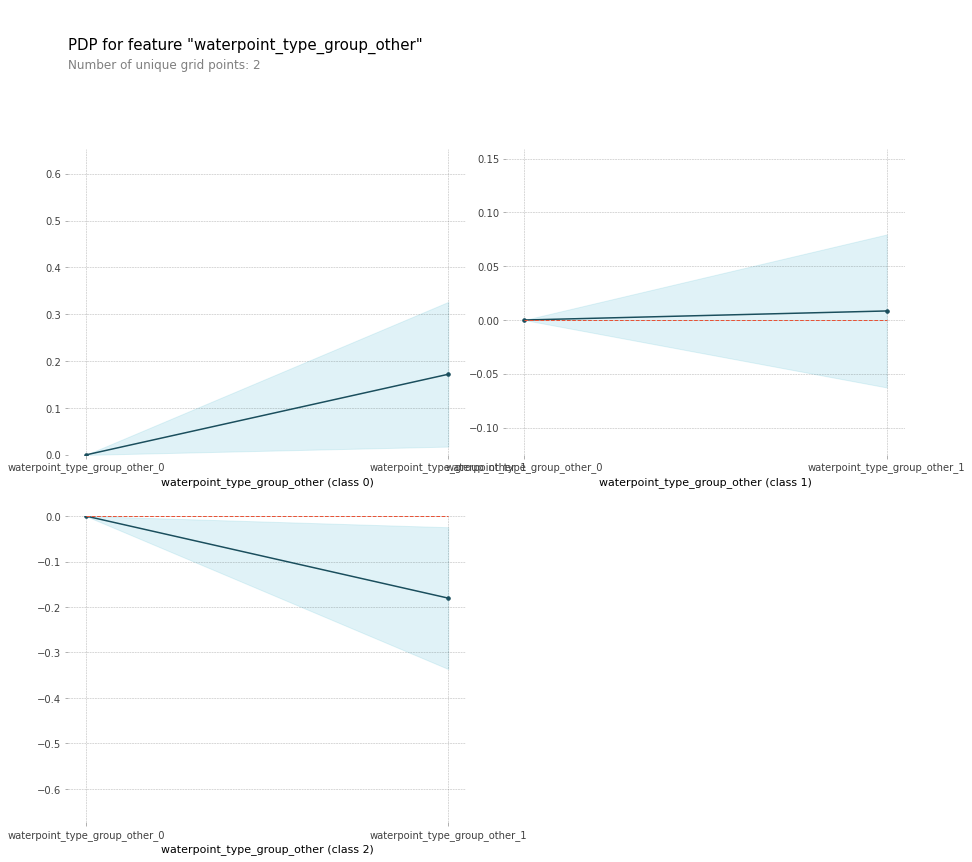

In [0]:
# PDP 3a - Waterpoint Group
feature_names = df_train.columns.tolist()
feature_to_plot = 'waterpoint_type_group_other'

pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val, model_features=feature_names, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

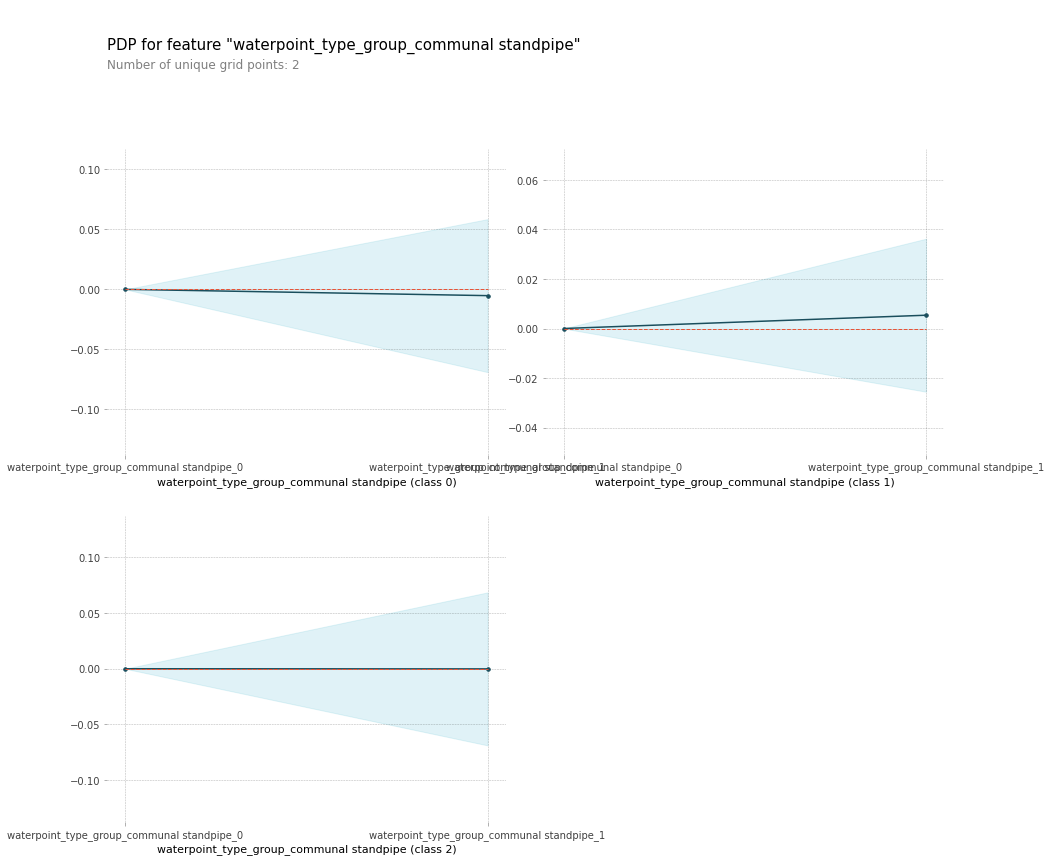

In [0]:
# PDP 3b - Waterpoint Group
feature_names = df_train.columns.tolist() 
feature_to_plot = 'waterpoint_type_group_communal standpipe' ## Majority 58% but no significant impact on the model

pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val, model_features=feature_names, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

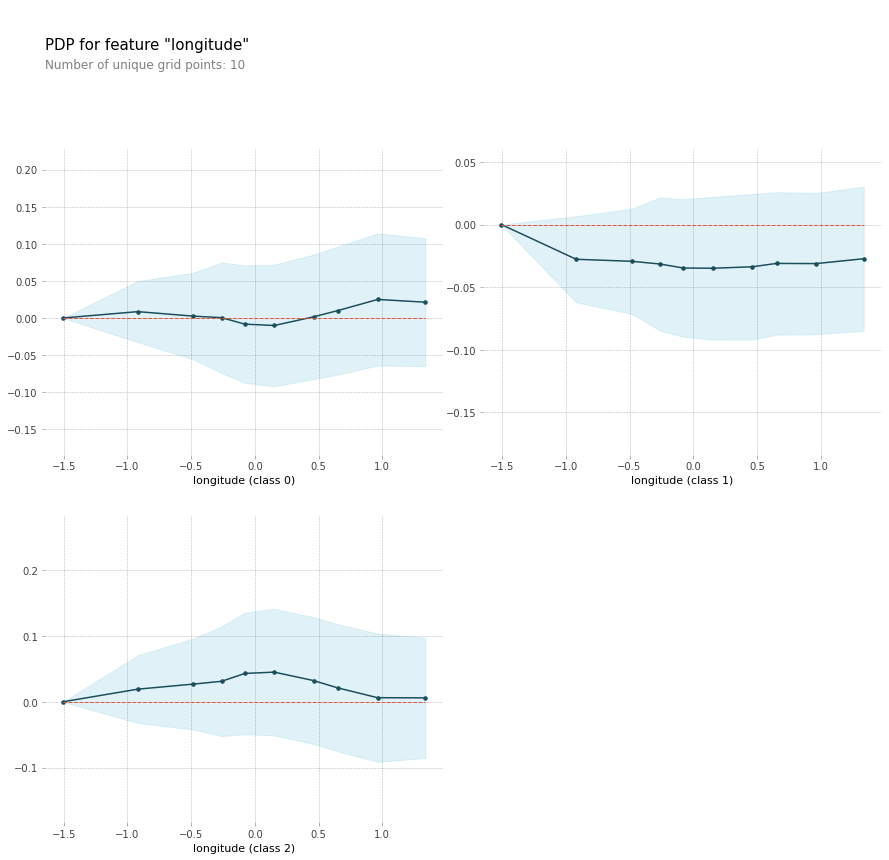

In [0]:
# PDP 4 - Longitude
feature_names = df_train.columns.tolist()
feature_to_plot = 'longitude'

pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val, model_features=feature_names, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

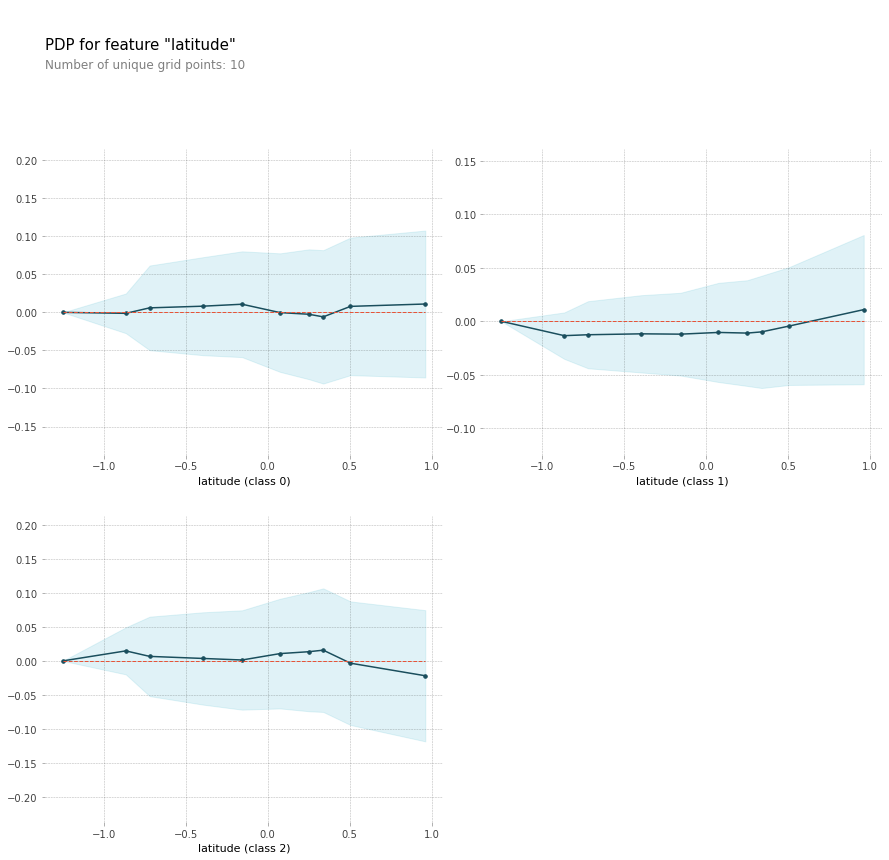

In [0]:
# PDP 5 - Latitude
feature_names = df_train.columns.tolist()
feature_to_plot = 'latitude'

pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val, model_features=feature_names, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

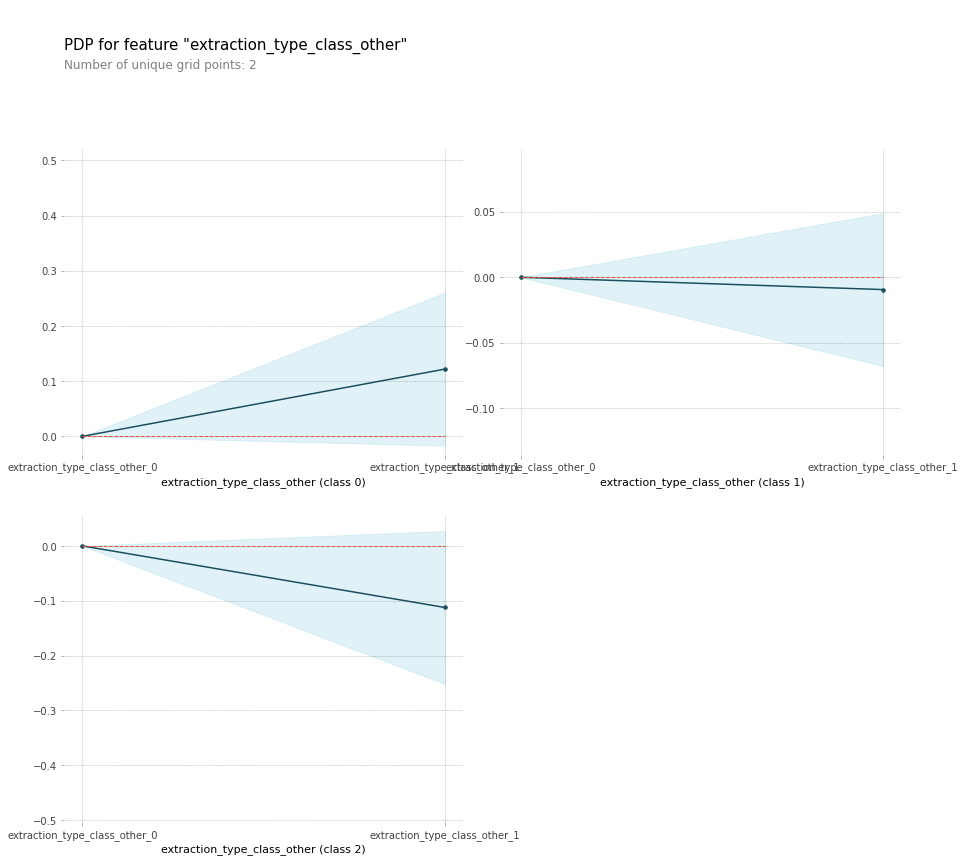

In [0]:
# PDP 6 - Extraction Type Class 
feature_names = df_train.columns.tolist()
feature_to_plot = 'extraction_type_class_other'

pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val, model_features=feature_names, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

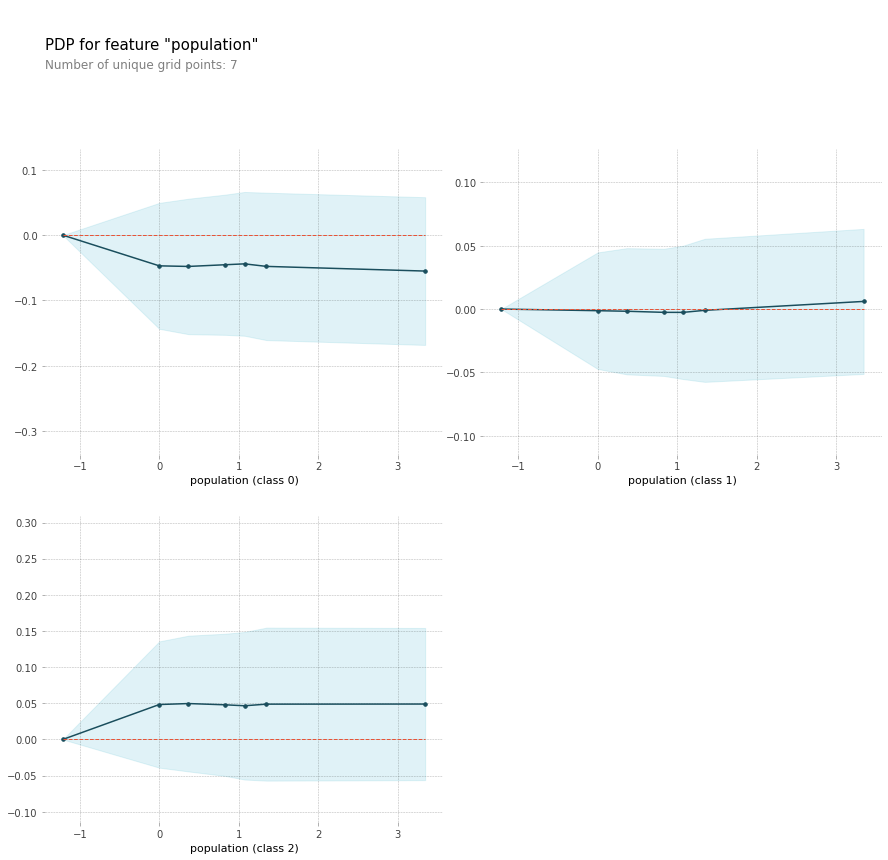

In [0]:
# PDP 7 - Population 
feature_names = df_train.columns.tolist()
feature_to_plot = 'population'

pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val, model_features=feature_names, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

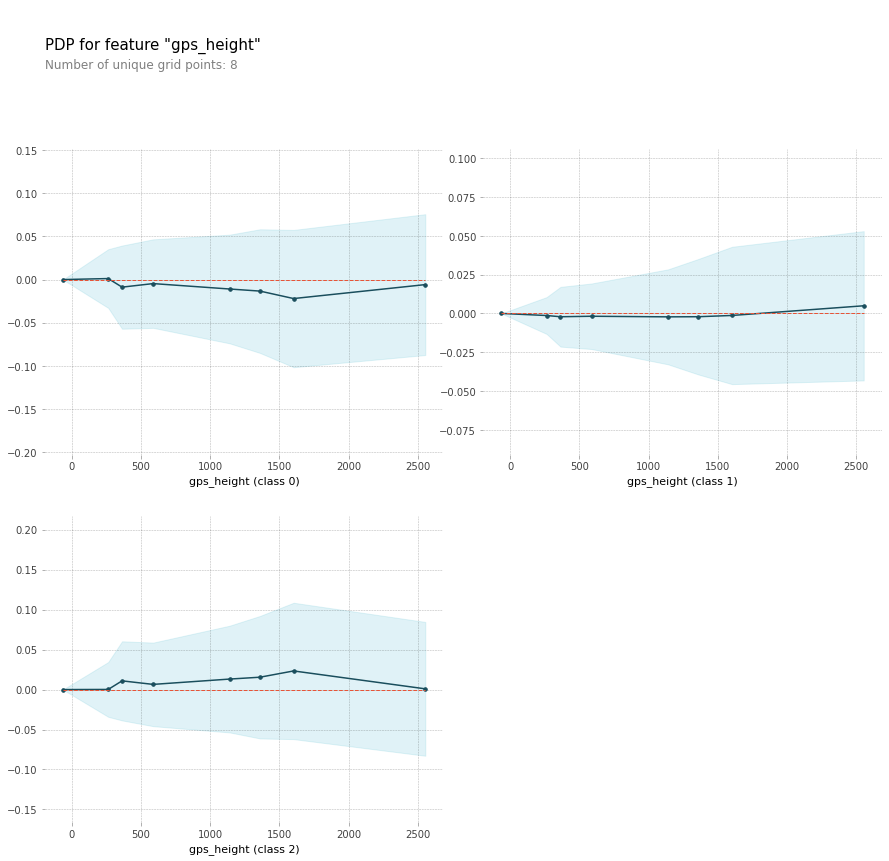

In [0]:
# PDP 8 - GPS height 
feature_names = df_train.columns.tolist()
feature_to_plot = 'gps_height'

pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val, model_features=feature_names, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

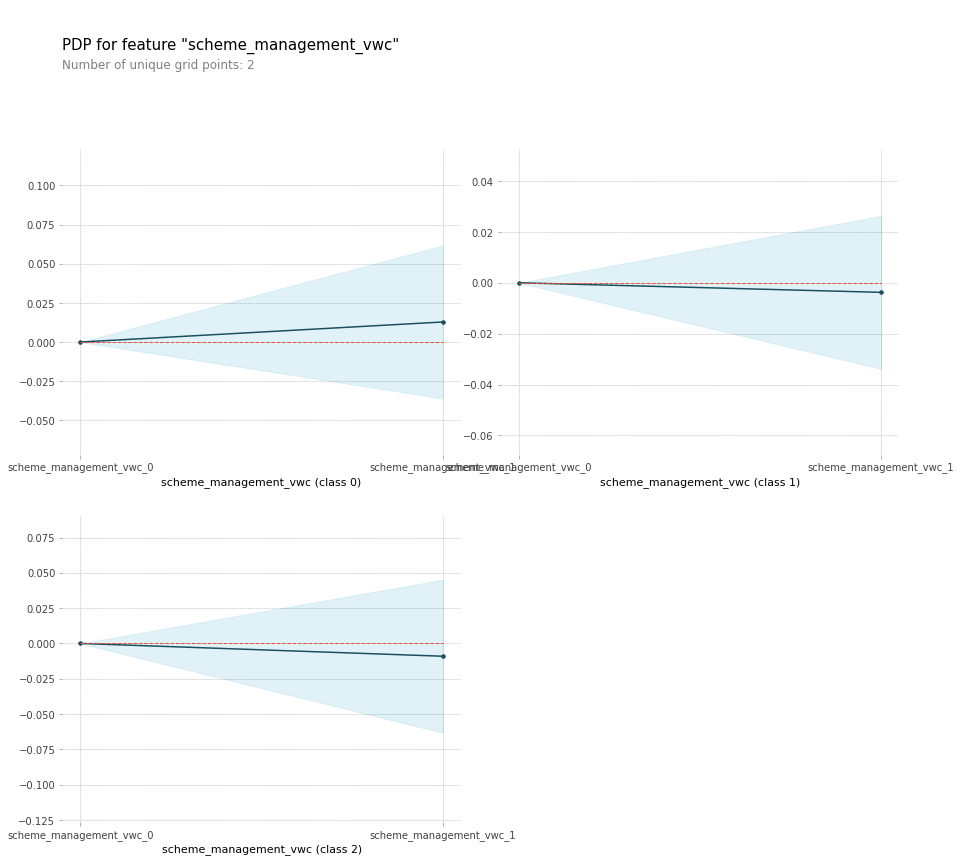

In [0]:
# PDP 9 - Scheme Management
feature_names = df_train.columns.tolist()
feature_to_plot = 'scheme_management_vwc'

pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val, model_features=feature_names, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

In [0]:
# Test dataset get accuracy of 81.06%, currently top 14% in the leaderboard.